## Overview

The purpose of this kernel is to take a look at the data, come up with some insights, and attempt to create a predictive model or two. So let's get started!

## Packages

First, let's load a few useful Python packages. This section will keep growing in subsequent versions of this EDA.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import operator
#import gc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import describe
%matplotlib inline

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import xgboost as xgb

Now let us look at the input folder. Here we find all the relevant files for this competition.

In [5]:
print(os.listdir("/Users/keisuke/Downloads/code/machineLearning/Santander"))

['.DS_Store', '.ipynb_checkpoints', 'data_decomposition.ipynb', 'kernel.ipynb', 'sample_submission.csv', 'sample_submission.csv.zip', 'submission.csv', 'test.csv', 'test.csv.zip', 'train.csv', 'train.csv.zip', 'yetEDA.ipynb']


We see that the input folder only contains three files ```train.csv```, ```test.csv```, and ```sample_submission.csv```. It seems that for this competition we don't have to do any complicated combination and mergers of files.

Now let's import and take a glimpse at these files.

In [6]:
train_df = pd.read_csv('train.csv')
train_df.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


In [7]:
train_df.shape

(4459, 4993)

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Columns: 4993 entries, ID to 9fc776466
dtypes: float64(1845), int64(3147), object(1)
memory usage: 169.9+ MB


In [11]:
train_df.isnull().values.any()

False

A few things immediately stand out:

1. As advertised, features are numeric and anonymized. 
2. Features seem sparse. We'll have to investigate this further. 
3. There are a LOT of features! Almost 5000! And they outnumber the number of rows in the training set!
4. There are less than 5000 training rows. In fact, there are fewer rows than columns, which means we'll have to invest a lot of effort into feature selection / feature engineering. 
5. The memory size of the train dataset is fairly large - 170 MB, which is to be expected. 
6. Pandas is treating 1845 features as float, and 3147 as integer. It is possible that some of those int features are one-hot-encoded or label-encoded categorical variables. We'll have to investigate this later, and possibly do some reverse-engineering. :)
7. There doesn't appear to be any missing values in the train set. This is, IMHO, overall a good thing, although a lot of times there is some signal in the missing values that's valuable and worth exploring. 

This is going to be a very, very, interesting competition. :)

Now let's take a look at the test dataset.

In [12]:
test_df = pd.read_csv('test.csv')
test_df.head()

,ID,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000137c73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00021489f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0004d7953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00056a333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00056d8eb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
test_df.shape

(49342, 4992)

In [14]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49342 entries, 0 to 49341
Columns: 4992 entries, ID to 9fc776466
dtypes: float64(4991), object(1)
memory usage: 1.8+ GB


In [15]:
test_df.isnull().values.any()

False

Here we see that the number of features in the test set (4992) matches the number in the train set. Sanity check is always a good thing, and at leas at this level, hte Kaggle people did not mess things up.

According to Pandas, there are no ```int``` values in the test set. Now I'm really curious about those ... 

There also doesn't seem to be any missing values in the test set. 

We also see that the number of rows in the test set far surpasses the number of rows in the train set. Yes, a very *interesting* competition indeed ...



Now let's see some basic descriptive statistics for the train and test dataframes.

In [16]:
train_df_describe = train_df.describe()
train_df_describe

,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
count,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,...,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4459.000000,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03
mean,5.944923e+06,1.465493e+04,1.390895e+03,2.672245e+04,4.530164e+03,2.640996e+04,3.070811e+04,1.686522e+04,4.669208e+03,2.569407e+06,...,4.676057e+05,4.446239e+05,8.056219e+05,7.812966e+05,143.529939,1.213809e+05,3.573451e+04,3.123741e+05,9.219960e+04,2.279100e+05
std,8.234312e+06,3.893298e+05,6.428302e+04,5.699652e+05,2.359124e+05,1.514730e+06,5.770590e+05,7.512756e+05,1.879449e+05,9.610183e+06,...,4.068038e+06,4.428889e+06,4.513246e+06,6.839451e+06,9584.318507,4.720709e+06,1.614622e+06,4.318501e+06,1.635993e+06,1.811139e+06
min,3.000000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.000000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.260000e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,8.000000e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+05,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,4.000000e+07,2.000000e+07,4.000000e+06,2.000000e+07,1.480000e+07,1.000000e+08,2.070800e+07,4.000000e+07,1.040000e+07,3.196120e+08,...,7.600000e+07,1.235880e+08,1.300000e+08,1.444000e+08,640000.000000,3.013120e+08,1.064200e+08,1.400000e+08,6.176800e+07,4.320000e+07


A few things to notice:

1.  Target variable ranges over 4 orders of magnitude. (factor of 10,000)
2. Most features have 0.0 for 75% - another indication that we are probably dealing with sparse data.
3. Most features seem to have similarly wide spread of values as the target variable. Hmm, interesting ...
4. The standard deviation for most features seems larger than the feature mean. 
5.. There are a few features (such as ```d5308d8bc```, ```c330f1a67```) that seem to be filled with zeros. These will need to be eliminated.

Now let's look at the test set. 

In [17]:
test_df_describe = test_df.describe()
test_df_describe

,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,dc5a8f1d8,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
count,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,...,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04
mean,5.773787e+04,6.258726e+04,1.036752e+05,6.289853e+04,6.713354e+04,8.083879e+04,6.181014e+04,5.515752e+04,1.406324e+06,8.128668e+04,...,1.193910e+05,1.355955e+05,3.242217e+05,1.437856e+05,9.302367e+04,8.047145e+04,6.076865e+04,1.323210e+05,1.675766e+05,1.282487e+05
std,1.745182e+06,2.322787e+06,2.586951e+06,2.765941e+06,3.206124e+06,2.845031e+06,2.780137e+06,1.923517e+06,6.872366e+06,2.378938e+06,...,3.115190e+06,2.598454e+06,3.782996e+06,3.663374e+06,5.041000e+06,2.100210e+06,2.040655e+06,3.592018e+06,3.761816e+06,2.413798e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.504447e+08,2.283295e+08,2.758171e+08,3.972621e+08,4.667591e+08,2.852223e+08,4.863751e+08,2.043290e+08,3.435658e+08,2.310167e+08,...,5.351692e+08,1.236547e+08,3.793398e+08,4.025480e+08,9.657530e+08,1.680065e+08,2.497913e+08,3.200000e+08,3.186300e+08,2.189782e+08


We see a similar distribution of various statistical aggregates, but by no means the same: seems like there soem substantial distribution shifts between the train and test sets. This will probably be another major concern when it comes to feature selection/engineering. 

Now let's do some plotting. We'll take a look at, naturally, the ```target``` variable. First, let's make a histogram of its raw value.

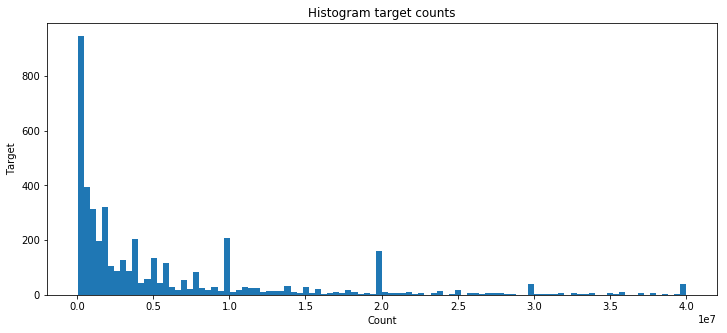

In [18]:
plt.figure(figsize=(12, 5))
plt.hist(train_df.target.values, bins=100)
plt.title('Histogram target counts')
plt.xlabel('Count')
plt.ylabel('Target')
plt.show()

This is a highly skewed distribution, so let's try to re-plot it with with log transform of the target.

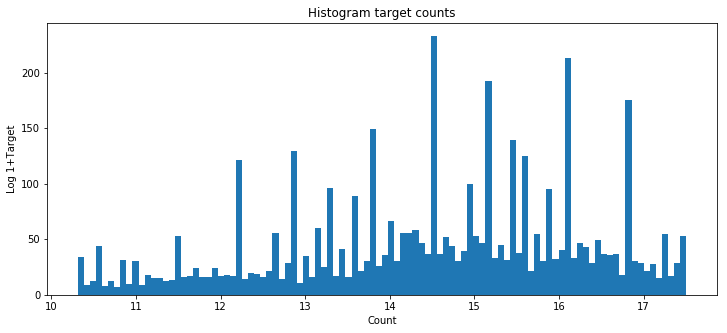

In [19]:
plt.figure(figsize=(12, 5))
plt.hist(np.log(1+train_df.target.values), bins=100)
plt.title('Histogram target counts')
plt.xlabel('Count')
plt.ylabel('Log 1+Target')
plt.show()

As expected, this distribution looks much more, ahem, normal. This is probably one of the main reasons why the metric that we are trying to optimize for this competition is RMSLE - root mean square logarithmic error.

Another way of looking at the same distribution is with the help of violinplot.

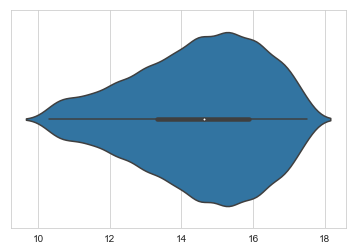

In [20]:
sns.set_style("whitegrid")
ax = sns.violinplot(x=np.log(1+train_df.target.values))
plt.show()

That's ... revealing. And it looks like a fairly nice distribution, albeit still fairly asymetrical.

Let's take a look at the statistics of the Log(1+target)

In [21]:
train_log_target = train_df[['target']]
train_log_target['target'] = np.log(1+train_df['target'].values)
train_log_target.describe()

/Users/keisuke/.pyenv/versions/3.6.1/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,target
count,4459.000000
mean,14.490239
std,1.750947
min,10.308986
25%,13.304687
50%,14.630876
75%,15.894952
max,17.504390


We see that the statistical properties of teh Log(1+Target) distribution are much more amenable.

Now let's take a look at columns with constant value.

In [22]:
constant_train = train_df.loc[:, (train_df == train_df.iloc[0]).all()].columns.tolist()
constant_test = test_df.loc[:, (test_df == test_df.iloc[0]).all()].columns.tolist()

In [29]:
print('Number of constant columns in the train set:', len(constant_train))
print('Number of constant columns in the test set:', len(constant_test))

Number of constant columns in the train set: 256
Number of constant columns in the test set: 0


So this is interesting: there are 256 constant columns in the train set, but none in the test set. These constant columns are thus most likely an artifact of the way that the train and test sets were constructed, and not necessarily irrelevant in their own right. This is yet another byproduct of having a very small dataset. For most problems it would be useful to take a look at the description of these columns, but in this competition they are anonymized, and thus would not yield any useful information. 

So let's subset the colums that we'd use to just those that are not constant.

In [30]:
columns_to_use = test_df.columns.tolist()
del columns_to_use[0] # Remove 'ID'
columns_to_use = [x for x in columns_to_use if x not in constant_train] #Remove all 0 columns
len(columns_to_use)

4735

So we have the total of 4735 columns to work with. However, as mentioned earlier, most of these columns seem to be filled predominatly with zeros. Let's try to get a better sense of this data.

In [31]:
describe(train_df[columns_to_use].values, axis=None)

DescribeResult(nobs=21113365, minmax=(0.0, 4652000000.0), mean=293258.52559507504, variance=30028281996743.3, skewness=311.8700933184134, kurtosis=234173.65118899167)

If we treat all the train matrix values as if they belonged to a single row vector, we see a huge amount of varience, far exceeding the similar variance for the target variable.

Now let's plot it to see how diverse the numerical values are.

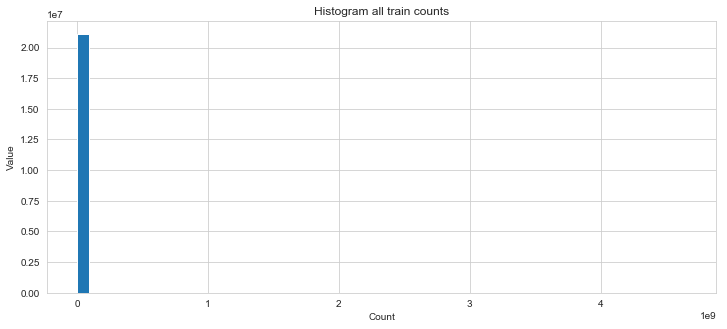

In [32]:
plt.figure(figsize=(12, 5))
plt.hist(train_df[columns_to_use].values.flatten(), bins=50)
plt.title('Histogram all train counts')
plt.xlabel('Count')
plt.ylabel('Value')
plt.show()

Wow, not very diverse at all! Most of the values are heavily concentrated around 0. 

Maybe if we used the log plot things would be better.

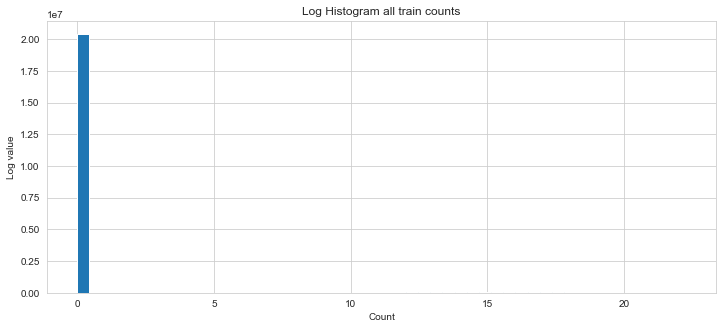

In [34]:
plt.figure(figsize=(12, 5))
plt.hist(np.log(train_df[columns_to_use].values.flatten()+1), bins=50)
plt.title('Log Histogram all train counts')
plt.xlabel('Count')
plt.ylabel('Log value')
plt.show()

Only marginal improvement - there is a verly small bump close to 15.

Can the violin plot help?

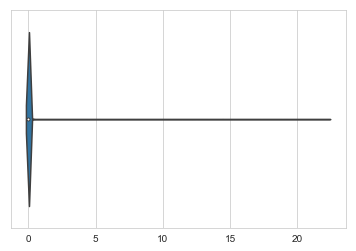

In [35]:
sns.set_style("whitegrid")
ax = sns.violinplot(x=np.log(train_df[columns_to_use].values.flatten()+1))
plt.show()

Not really - the plot looks nicer, but the overall shape is pretty much the same. 

OK, let's take a look at the distribution of non-zero values.

In [37]:
train_nz

array([14.07787559, 15.28184786, 16.39572746, ..., 15.96727288,
       16.70588237, 16.11809575])

In [41]:
kei = np.nonzero(train_df[columns_to_use].values)

(array([   0,    0,    0, ..., 4458, 4458, 4458]),
 array([  34,  103,  113, ..., 4647, 4673, 4686]))

In [50]:
train[kei]

NameError: name 'train' is not defined

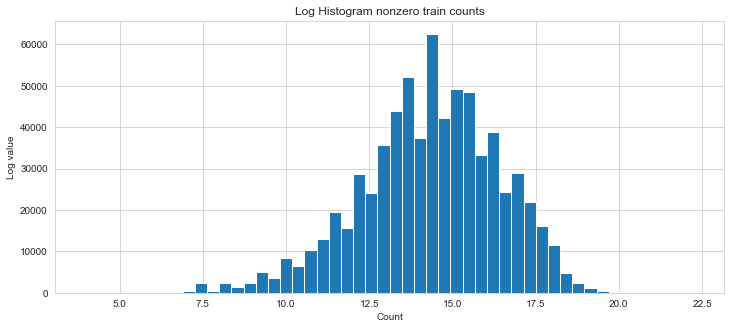

In [36]:
train_nz = np.log(train_df[columns_to_use].values.flatten()+1)
train_nz = train_nz[np.nonzero(train_nz)]
plt.figure(figsize=(12, 5))
plt.hist(train_nz, bins=50)
plt.title('Log Histogram nonzero train counts')
plt.xlabel('Count')
plt.ylabel('Log value')
plt.show()

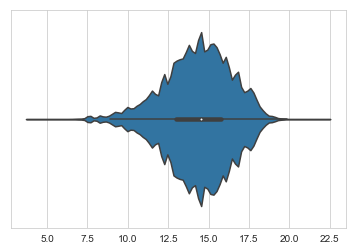

In [59]:
sns.set_style("whitegrid")
ax = sns.violinplot(x=train_nz)
plt.show()

In [60]:
describe(train_nz)

DescribeResult(nobs=700109, minmax=(3.970291913552122, 22.260563071817792), mean=14.316623220268225, variance=4.4093394490175815, skewness=-0.4469438901987079, kurtosis=0.2590730075122565)

OK, that's much more interesting. 

Let's do the same thing with the test data.

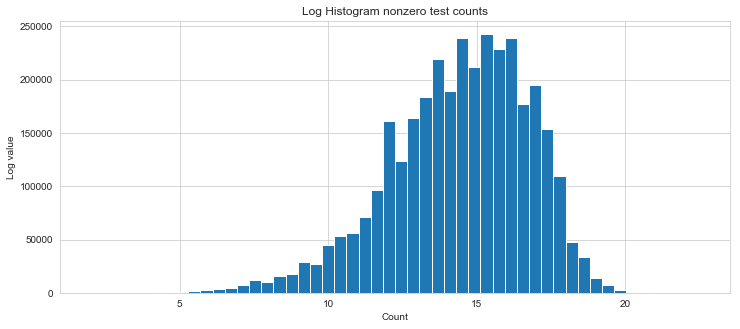

In [61]:
test_nz = np.log(test_df[columns_to_use].values.flatten()+1)
test_nz = test_nz[np.nonzero(test_nz)]
plt.figure(figsize=(12, 5))
plt.hist(test_nz, bins=50)
plt.title('Log Histogram nonzero test counts')
plt.xlabel('Count')
plt.ylabel('Log value')
plt.show()

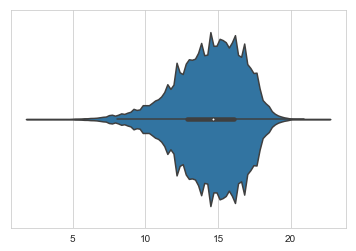

In [62]:
sns.set_style("whitegrid")
ax = sns.violinplot(x=test_nz)
plt.show()

In [63]:
describe(test_nz)

DescribeResult(nobs=3402015, minmax=(2.0086157469070973, 22.503422149195277), mean=14.412378376537879, variance=5.547651949802501, skewness=-0.6259111391462195, kurtosis=0.3990742424795699)

Again, we see that these distributions look similar, but they are definitely not the same. 

Now let's take a closer look at the shape and content of the train data. We want to get a better numerical grasp of the true extent of zeros.

In [67]:
train_df[columns_to_use].values.flatten().shape

(21113365,)

In [65]:
((train_df[columns_to_use].values.flatten())==0).mean()

0.9668404823200849

So as we suspected, almost 97% of all values in the train dataframe are zeros. That looks pretty sparse to me, but let's see how much variation is there between different columns.

In [70]:
train_zeros = pd.DataFrame({'Percentile':((train_df[columns_to_use].values)==0).mean(axis=0),
                           'Column' : columns_to_use})
train_zeros.head()

,Percentile,Column
0,0.991254,48df886f9
1,0.999103,0deb4b6a8
2,0.992599,34b15f335
3,0.999551,a8cb14b00
4,0.998879,2f0771a37


In [77]:
describe(train_zeros.Percentile.values)

DescribeResult(nobs=4735, minmax=(0.6490244449428123, 0.999775734469612), mean=0.9668404823200848, variance=0.002364379746472081, skewness=-3.0652241198889913, kurtosis=12.91866341515125)

So it seems that the vast majority of columns have 95+ percent of zeros in them. Let's see how would that look on a plot.

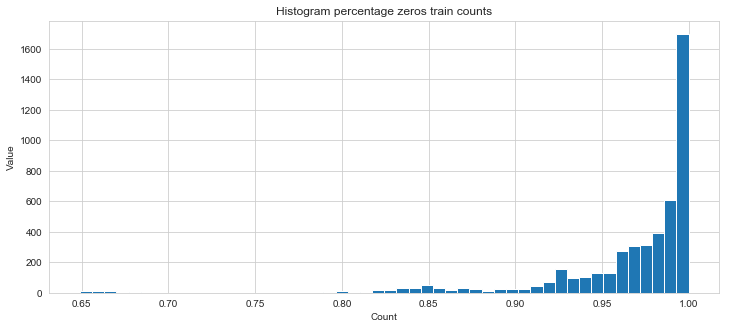

In [78]:
plt.figure(figsize=(12, 5))
plt.hist(train_zeros.Percentile.values, bins=50)
plt.title('Histogram percentage zeros train counts')
plt.xlabel('Count')
plt.ylabel('Value')
plt.show()

In [79]:
describe(np.log(train_df[columns_to_use].values+1), axis=None)

DescribeResult(nobs=21113365, minmax=(0.0, 22.260563071817792), mean=0.4747323207891672, variance=6.717404669554313, skewness=5.38608469493144, kurtosis=27.58080786335338)

In [80]:
describe(test_df[columns_to_use].values, axis=None)

DescribeResult(nobs=233634370, minmax=(0.0, 5930783399.23079), mean=168464.1181982833, variance=19686658498586.707, skewness=297.586650843169, kurtosis=260104.68553477703)

In [81]:
describe(np.log(test_df[columns_to_use].values+1), axis=None)

DescribeResult(nobs=233634370, minmax=(0.0, 22.503422149195277), mean=0.20986264744633906, variance=3.0613584426687614, skewness=8.406607428136079, kurtosis=70.08947561815806)

In [82]:
test_zeros = pd.DataFrame({'Percentile':(np.log(1+test_df[columns_to_use].values)==0).mean(axis=0),
                           'Column' : columns_to_use})
test_zeros.head()

,Percentile,Column
0,0.994204,48df886f9
1,0.996028,0deb4b6a8
2,0.989218,34b15f335
3,0.995866,a8cb14b00
4,0.996352,2f0771a37


In [83]:
describe(test_zeros.Percentile.values)

DescribeResult(nobs=4735, minmax=(0.8368327185764664, 0.9966965262859228), mean=0.9854387220510409, variance=0.0003225586648390302, skewness=-3.8759625696317483, kurtosis=20.273655656625518)

OK, let's try to do some modeling. We'll start with a simple LighGBM regression, and see if that yields any results. First, let's set our target variable to be the log of 1 + target.

In [91]:
y = np.log(1+train_df.target.values)
y.shape

(4459,)

In [92]:
y

array([17.45309674, 13.3046866 , 16.11809575, ..., 14.84513033,
       16.11809575, 16.81124288])

In [93]:
train = lgb.Dataset(train_df[columns_to_use],y ,feature_name = "auto")

In [95]:
params = {'boosting_type': 'gbdt', 
          'objective': 'regression', 
          'metric': 'rmse', 
          'learning_rate': 0.01, 
          'num_leaves': 100, 
          'feature_fraction': 0.4, 
          'bagging_fraction': 0.6, 
          'max_depth': 5, 
          'min_child_weight': 10}

clf = lgb.train(params,
        train,
        num_boost_round = 400,
        verbose_eval=True)

In [109]:
# data_decompositionからの引用で検証。

from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(train_df, y, test_size=0.20, random_state=2018)
train_X = lgb.Dataset(train_x[columns_to_use], label=train_y)
val_X = lgb.Dataset(val_x[columns_to_use], label=val_y)
model1 = lgb.train(params, train_X, 1000, val_X, verbose_eval=100, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.61067
[200]	valid_0's rmse: 1.54074
[300]	valid_0's rmse: 1.5083
[400]	valid_0's rmse: 1.48934
[500]	valid_0's rmse: 1.47823
[600]	valid_0's rmse: 1.47108
[700]	valid_0's rmse: 1.46526
[800]	valid_0's rmse: 1.46205
[900]	valid_0's rmse: 1.46011
[1000]	valid_0's rmse: 1.4581
Did not meet early stopping. Best iteration is:
[997]	valid_0's rmse: 1.45804


In [96]:
preds = clf.predict(test_df[columns_to_use])
preds

array([14.42327409, 14.42327409, 14.53871878, ..., 14.24748285,
       13.84353729, 14.42760526])

In [110]:
sample_submission = pd.read_csv("sample_submission.csv")

In [119]:
# sample_submissionとtest_dfの IDも数も同じ。違いはtargetのみ。sample_submissionはランダムな値。

sample_submission.target = np.exp(preds)-1
sample_submission.to_csv('simple_lgbm_1.csv', index=False)
sample_submission.head()

,ID,target
0,000137c73,1.836319e+06
1,00021489f,1.836319e+06
2,0004d7953,2.061034e+06
3,00056a333,3.658886e+06
4,00056d8eb,1.836319e+06


Well, that's great - we made a prediction on the test set, and saved it to a file, which we were able to submit to the competition. Unfortunately, there was no way to tell how this model would perform on the unseen data. (This submission scored 1.53 on Public Leaderboard.)

In [ ]:
nr_splits = 5
random_state = 1054

y_oof = np.zeros((y.shape[0]))
total_preds = 0


kf = KFold(n_splits=nr_splits, shuffle=True, random_state=random_state)
for i, (train_index, val_index) in enumerate(kf.split(y)):
    print('Fitting fold', i+1, 'out of', nr_splits)
    X_train, X_val  = train_df[columns_to_use].iloc[train_index], train_df[columns_to_use].iloc[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    train = lgb.Dataset(X_train,y_train ,feature_name = "auto")
    val = lgb.Dataset(X_val ,y_val ,feature_name = "auto")
    clf = lgb.train(params,train,num_boost_round = 400,verbose_eval=True)
    
    total_preds += clf.predict(test_df[columns_to_use])/nr_splits
    pred_oof = clf.predict(X_val)
    y_oof[val_index] = pred_oof
    print('Fold error', np.sqrt(mean_squared_error(y_val, pred_oof)))

print('Total error', np.sqrt(mean_squared_error(y, y_oof)))

In [ ]:
params['max_depth'] = 4

y_oof_2 = np.zeros((y.shape[0]))
total_preds_2 = 0


kf = KFold(n_splits=nr_splits, shuffle=True, random_state=random_state)
for i, (train_index, val_index) in enumerate(kf.split(y)):
    print('Fitting fold', i+1, 'out of', nr_splits)
    X_train, X_val  = train_df[columns_to_use].iloc[train_index], train_df[columns_to_use].iloc[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    train = lgb.Dataset(X_train,y_train ,feature_name = "auto")
    val = lgb.Dataset(X_val ,y_val ,feature_name = "auto")
    clf = lgb.train(params,train,num_boost_round = 400,verbose_eval=True)
    
    total_preds_2 += clf.predict(test_df[columns_to_use])/nr_splits
    pred_oof = clf.predict(X_val)
    y_oof_2[val_index] = pred_oof
    print('Fold error', np.sqrt(mean_squared_error(y_val, pred_oof)))

print('Total error', np.sqrt(mean_squared_error(y, y_oof_2)))

In [ ]:
params['max_depth'] = 6

y_oof_3 = np.zeros((y.shape[0]))
total_preds_3 = 0


kf = KFold(n_splits=nr_splits, shuffle=True, random_state=random_state)
for i, (train_index, val_index) in enumerate(kf.split(y)):
    print('Fitting fold', i+1, 'out of', nr_splits)
    X_train, X_val  = train_df[columns_to_use].iloc[train_index], train_df[columns_to_use].iloc[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    train = lgb.Dataset(X_train,y_train ,feature_name = "auto")
    val = lgb.Dataset(X_val ,y_val ,feature_name = "auto")
    clf = lgb.train(params,train,num_boost_round = 400,verbose_eval=True)
    
    total_preds_3 += clf.predict(test_df[columns_to_use])/nr_splits
    pred_oof = clf.predict(X_val)
    y_oof_3[val_index] = pred_oof
    print('Fold error', np.sqrt(mean_squared_error(y_val, pred_oof)))

print('Total error', np.sqrt(mean_squared_error(y, y_oof_3)))

In [ ]:
params['max_depth'] = 7

y_oof_4 = np.zeros((y.shape[0]))
total_preds_4 = 0


kf = KFold(n_splits=nr_splits, shuffle=True, random_state=random_state)
for i, (train_index, val_index) in enumerate(kf.split(y)):
    print('Fitting fold', i+1, 'out of', nr_splits)
    X_train, X_val  = train_df[columns_to_use].iloc[train_index], train_df[columns_to_use].iloc[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    train = lgb.Dataset(X_train,y_train ,feature_name = "auto")
    val = lgb.Dataset(X_val ,y_val ,feature_name = "auto")
    clf = lgb.train(params,train,num_boost_round = 400,verbose_eval=True)
    
    total_preds_4 += clf.predict(test_df[columns_to_use])/nr_splits
    pred_oof = clf.predict(X_val)
    y_oof_4[val_index] = pred_oof
    print('Fold error', np.sqrt(mean_squared_error(y_val, pred_oof)))

print('Total error', np.sqrt(mean_squared_error(y, y_oof_4)))

In [ ]:
params['max_depth'] = 8

y_oof_5 = np.zeros((y.shape[0]))
total_preds_5 = 0


kf = KFold(n_splits=nr_splits, shuffle=True, random_state=random_state)
for i, (train_index, val_index) in enumerate(kf.split(y)):
    print('Fitting fold', i+1, 'out of', nr_splits)
    X_train, X_val  = train_df[columns_to_use].iloc[train_index], train_df[columns_to_use].iloc[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    train = lgb.Dataset(X_train,y_train ,feature_name = "auto")
    val = lgb.Dataset(X_val ,y_val ,feature_name = "auto")
    clf = lgb.train(params,train,num_boost_round = 400,verbose_eval=True)
    
    total_preds_5 += clf.predict(test_df[columns_to_use])/nr_splits
    pred_oof = clf.predict(X_val)
    y_oof_5[val_index] = pred_oof
    print('Fold error', np.sqrt(mean_squared_error(y_val, pred_oof)))

print('Total error', np.sqrt(mean_squared_error(y, y_oof_5)))

In [ ]:
params['max_depth'] = 10

y_oof_6 = np.zeros((y.shape[0]))
total_preds_6 = 0


kf = KFold(n_splits=nr_splits, shuffle=True, random_state=random_state)
for i, (train_index, val_index) in enumerate(kf.split(y)):
    print('Fitting fold', i+1, 'out of', nr_splits)
    X_train, X_val  = train_df[columns_to_use].iloc[train_index], train_df[columns_to_use].iloc[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    train = lgb.Dataset(X_train,y_train ,feature_name = "auto")
    val = lgb.Dataset(X_val ,y_val ,feature_name = "auto")
    clf = lgb.train(params,train,num_boost_round = 400,verbose_eval=True)
    
    total_preds_6 += clf.predict(test_df[columns_to_use])/nr_splits
    pred_oof = clf.predict(X_val)
    y_oof_6[val_index] = pred_oof
    print('Fold error', np.sqrt(mean_squared_error(y_val, pred_oof)))

print('Total error', np.sqrt(mean_squared_error(y, y_oof_6)))

In [ ]:
params['max_depth'] = 12

y_oof_7 = np.zeros((y.shape[0]))
total_preds_7 = 0


kf = KFold(n_splits=nr_splits, shuffle=True, random_state=random_state)
for i, (train_index, val_index) in enumerate(kf.split(y)):
    print('Fitting fold', i+1, 'out of', nr_splits)
    X_train, X_val  = train_df[columns_to_use].iloc[train_index], train_df[columns_to_use].iloc[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    train = lgb.Dataset(X_train,y_train ,feature_name = "auto")
    val = lgb.Dataset(X_val ,y_val ,feature_name = "auto")
    clf = lgb.train(params,train,num_boost_round = 400,verbose_eval=True)
    
    total_preds_7 += clf.predict(test_df[columns_to_use])/nr_splits
    pred_oof = clf.predict(X_val)
    y_oof_7[val_index] = pred_oof
    print('Fold error', np.sqrt(mean_squared_error(y_val, pred_oof)))

print('Total error', np.sqrt(mean_squared_error(y, y_oof_7)))

In [ ]:
print('Total error', np.sqrt(mean_squared_error(y, 1.4*(1.6*y_oof_7-0.6*y_oof_6)-0.4*y_oof_5)))

In [ ]:
print('Total error', np.sqrt(mean_squared_error(y, -0.5*y_oof-0.5*y_oof_2-y_oof_3
                                                +3*y_oof_4)))

In [ ]:
print('Total error', np.sqrt(mean_squared_error(y, 0.75*(1.4*(1.6*y_oof_7-0.6*y_oof_6)-0.4*y_oof_5)+
                                                0.25*(-0.5*y_oof-0.5*y_oof_2-y_oof_3
                                                +3*y_oof_4))))

In [ ]:
sub_preds = (0.75*(1.4*(1.6*total_preds_7-0.6*total_preds_6)-0.4*total_preds_5)+
                                                0.25*(-0.5*total_preds-0.5*total_preds_2-total_preds_3
                                                +3*total_preds_4))
#sub_preds = (-0.5*total_preds-0.5*total_preds_2-total_preds_3+3*total_preds_4)
sample_submission.target = np.exp(sub_preds)-1
sample_submission.to_csv('blended_submission_2.csv', index=False)
sample_submission.head()

In [ ]:
params = {'objective': 'reg:linear', 
          'eval_metric': 'rmse',
          'eta': 0.01,
          'max_depth': 10, 
          'subsample': 0.6, 
          'colsample_bytree': 0.6,
          'alpha':0.001,
          'random_state': 42, 
          'silent': True}

y_oof_8 = np.zeros((y.shape[0]))
total_preds_8 = 0

dtest = xgb.DMatrix(test_df[columns_to_use])

kf = KFold(n_splits=nr_splits, shuffle=True, random_state=random_state)
for i, (train_index, val_index) in enumerate(kf.split(y)):
    print('Fitting fold', i+1, 'out of', nr_splits)
    X_train, X_val  = train_df[columns_to_use].iloc[train_index], train_df[columns_to_use].iloc[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    
    train = xgb.DMatrix(X_train, y_train)
    val = xgb.DMatrix(X_val, y_val)
    
    watchlist = [(train, 'train'), (val, 'val')]
    
    clf = xgb.train(params, train, 1000, watchlist, 
                          maximize=False, early_stopping_rounds = 60, verbose_eval=100)

    
    total_preds_8 += clf.predict(dtest, ntree_limit=clf.best_ntree_limit)/nr_splits
    pred_oof = clf.predict(val, ntree_limit=clf.best_ntree_limit)
    y_oof_8[val_index] = pred_oof
    print('Fold error', np.sqrt(mean_squared_error(y_val, pred_oof)))

print('Total error', np.sqrt(mean_squared_error(y, y_oof_8)))

### To do:

1. Meke some plots
2. Build a few models
3. Do feature importance analysis

## To be continued ...

In [ ]:
print('Total error', np.sqrt(mean_squared_error(y, 0.7*(0.75*(1.4*(1.6*y_oof_7-0.6*y_oof_6)-0.4*y_oof_5)+
                                                0.25*(-0.5*y_oof-0.5*y_oof_2-y_oof_3
                                                +3*y_oof_4))+0.3*y_oof_8)))

In [ ]:
sub_preds = (0.7*(0.75*(1.4*(1.6*total_preds_7-0.6*total_preds_6)-0.4*total_preds_5)+
                                                0.25*(-0.5*total_preds-0.5*total_preds_2-total_preds_3
                                                +3*total_preds_4))+0.3*total_preds_8)
#sub_preds = (-0.5*total_preds-0.5*total_preds_2-total_preds_3+3*total_preds_4)
sample_submission.target = np.exp(sub_preds)-1
sample_submission.to_csv('blended_submission_3.csv', index=False)
sample_submission.head()

In [ ]:
feature_importances = clf.get_fscore()

In [ ]:
importance = sorted(feature_importances.items(), key=operator.itemgetter(1))

In [ ]:
best_2500 = importance[::-1][:2500]

In [ ]:
best_2500 =[ x[0] for x in best_2500]

In [ ]:
params = {'objective': 'reg:linear', 
          'eval_metric': 'rmse',
          'eta': 0.01,
          'max_depth': 10, 
          'subsample': 0.6, 
          'colsample_bytree': 0.6,
          'alpha':0.001,
          'random_state': 42, 
          'silent': True}

y_oof_9 = np.zeros((y.shape[0]))
total_preds_9 = 0

dtest = xgb.DMatrix(test_df[best_2500])

kf = KFold(n_splits=nr_splits, shuffle=True, random_state=random_state)
for i, (train_index, val_index) in enumerate(kf.split(y)):
    print('Fitting fold', i+1, 'out of', nr_splits)
    X_train, X_val  = train_df[best_2500].iloc[train_index], train_df[best_2500].iloc[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    
    train = xgb.DMatrix(X_train, y_train)
    val = xgb.DMatrix(X_val, y_val)
    
    watchlist = [(train, 'train'), (val, 'val')]
    
    clf = xgb.train(params, train, 1500, watchlist, 
                          maximize=False, early_stopping_rounds = 60, verbose_eval=100)

    
    total_preds_9 += clf.predict(dtest, ntree_limit=clf.best_ntree_limit)/nr_splits
    pred_oof = clf.predict(val, ntree_limit=clf.best_ntree_limit)
    y_oof_9[val_index] = pred_oof
    print('Fold error', np.sqrt(mean_squared_error(y_val, pred_oof)))

print('Total error', np.sqrt(mean_squared_error(y, y_oof_9)))

In [ ]:
print('Total error', np.sqrt(mean_squared_error(y, 0.5*y_oof_9+0.5*(0.7*(0.75*(1.4*(1.6*y_oof_7-0.6*y_oof_6)-0.4*y_oof_5)+
                                                0.25*(-0.5*y_oof-0.5*y_oof_2-y_oof_3
                                                +3*y_oof_4))+0.3*y_oof_8))))

sub_preds = 0.5*total_preds_9+0.5*(0.7*(0.75*(1.4*(1.6*total_preds_7-0.6*total_preds_6)-0.4*total_preds_5)+
                                                0.25*(-0.5*total_preds-0.5*total_preds_2-total_preds_3
                                                +3*total_preds_4))+0.3*total_preds_8)
#sub_preds = (-0.5*total_preds-0.5*total_preds_2-total_preds_3+3*total_preds_4)
sample_submission.target = np.exp(sub_preds)-1
sample_submission.to_csv('blended_submission_4.csv', index=False)
sample_submission.head()